In [1]:
########################################
# 0. 환경 설정 & 라이브러리 설치
########################################
# Google Drive 연동
from google.colab import drive
drive.mount('/content/gdrive')

# 필요시 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn

########################################
# 1. 라이브러리 import
########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import optuna

# statsmodels (SARIMAX)
import statsmodels.api as sm

# prophet
from prophet import Prophet

# tensorflow / keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D)
# TCN
from tcn import TCN

import gc

In [3]:
########################################
# 2. 데이터 로드 & 기본 전처리
########################################
try:
    # 여러 인코딩 시도
    df_path = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled.csv'
    try:
        df = pd.read_csv(df_path, encoding='cp949')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(df_path, encoding='latin-1')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(df_path, encoding='cp1252')
            except UnicodeDecodeError:
                print("[ERROR] Could not decode file with common encodings.")
                raise
    print("[INFO] CSV file loaded successfully.")
except FileNotFoundError as fe:
    print(f"[ERROR] File not found: {df_path}")
    raise fe
except Exception as e:
    print("[ERROR] Unexpected error occurred while loading CSV.")
    raise e


[INFO] CSV file loaded successfully.


In [4]:
# 날짜 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

print("\n=== 데이터 상위 5행 ===")
print(df.head())
print("\n=== 데이터 info ===")
print(df.info())
print("\n=== 데이터 describe ===")
print(df.describe())



=== 데이터 상위 5행 ===
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01      0  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02      0  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03      0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04      3  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05      3  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최저기온(℃)  평균일강수량(mm)  최다일강수량(mm)  \
0  47.416719      2.2        7.8  ...     -6.8         0.0         0.2   
1  52.897434      2.1        7.8  ...    -11.2         0.0         0.7   
2  21.600817      1.3        5.7  ...     -9.7         0.0         0.7   
3  18.842018      0.1        6.3  ...    -18.6         0.3         2.0   
4  11.594881     -3.6        1.0  ...    -18.9         0.0        26.0   

   평균풍속(m/s)  최대풍속(m/s)  최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  \
0        1.5       1

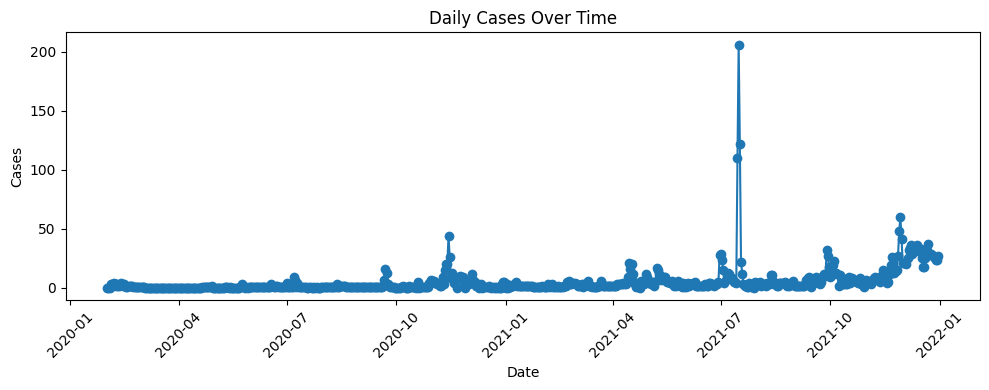

In [5]:
# EDA 시각화(기본)
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("Daily Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
########################################
# 3. 이상치 처리 & 추가 특징 공학
########################################
# (1) IQR 방법으로 이상치 상한 클리핑
Q1 = df['Cases'].quantile(0.25)
Q3 = df['Cases'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5*IQR
df['Cases'] = np.where(df['Cases']>upper_bound, upper_bound, df['Cases'])

# (2) 몇 개의 lag/rolling/차분 예시
df['Cases_lag1'] = df['Cases'].shift(1)
df['Cases_lag7'] = df['Cases'].shift(7)
for ws in [7,14]:
    df[f'Cases_ma{ws}'] = df['Cases'].rolling(ws).mean()
    df[f'Cases_std{ws}'] = df['Cases'].rolling(ws).std()
df['Cases_log'] = np.log1p(df['Cases'])
df['Cases_diff'] = df['Cases'].diff(1)

# 결측치 제거(shift/rolling 후 생긴)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [30]:
df.head()

,Date,Cases,SO2,CO,O3,NO2,PM10,PM25,평균기온(℃),평균최고기온(℃),...,Cases_ma14,Cases_std14,Cases_log,Cases_diff,Cases_lag3,Cases_lag5,Cases_lag14,Cases_diff1,Cases_diff7,Cases_boxcox
0,2020-03-26,0.0,0.003219,0.480759,0.029215,0.025046,41.351981,25.678222,13.2,18.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.730954
1,2020-03-27,0.0,0.002832,0.430229,0.027567,0.014411,32.596243,17.361976,11.4,16.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.730954
2,2020-03-28,0.0,0.002859,0.338840,0.032349,0.010192,35.425246,9.260116,7.0,11.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.730954
3,2020-03-29,0.0,0.002961,0.383257,0.032536,0.012404,35.242311,13.422099,7.5,14.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.730954
4,2020-03-30,0.0,0.003389,0.423885,0.032233,0.019698,38.698943,18.684129,9.9,16.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.730954


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/us

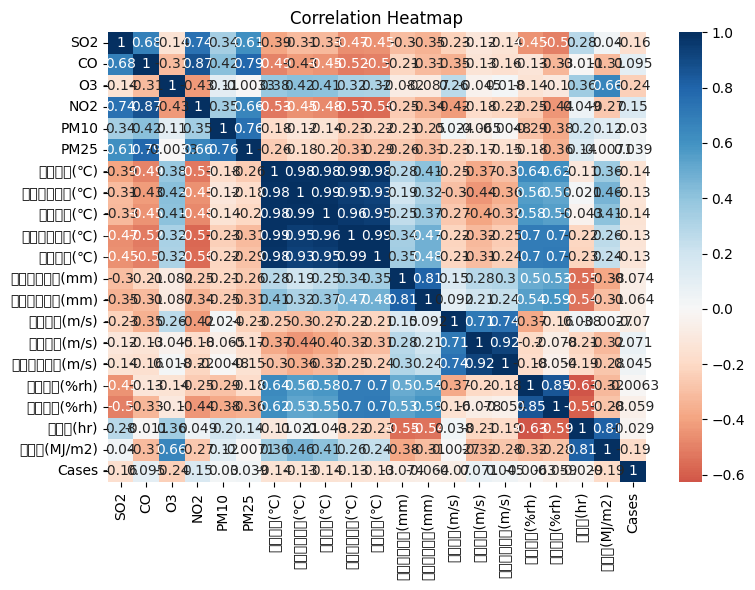

In [31]:
# EDA(상관관계 히트맵)
cols_for_corr = [    "SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)","Cases"]
plt.figure(figsize=(8,6))
sns.heatmap(df[cols_for_corr].corr(), annot=True, cmap='RdBu', center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [32]:
########################################
# 4. Train/Val/Test 분할 (날짜 기준)
########################################
train_end_date = pd.to_datetime('2021-05-01')
val_end_date   = pd.to_datetime('2021-07-01')

train_df = df[df['Date'] < train_end_date]
val_df   = df[(df['Date']>=train_end_date)&(df['Date']<val_end_date)]
test_df  = df[df['Date'] >= val_end_date]

print(f"Train={train_df.shape}, Val={val_df.shape}, Test={test_df.shape}")

Train=(401, 36), Val=(61, 36), Test=(184, 36)


In [64]:
########################################
# 5. 랜덤 포레스트 (회귀)
########################################
rf_features = [    "SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",'Cases_lag1','Cases_lag7']
X_train_rf = train_df[rf_features]
y_train_rf = train_df['Cases']
X_val_rf   = val_df[rf_features]
y_val_rf   = val_df['Cases']
X_test_rf  = test_df[rf_features]
y_test_rf  = test_df['Cases']

# TimeSeriesSplit + GridSearchCV
rf_params = {
    'n_estimators':[50,100],
    'max_depth':[3,5,7],
    'min_samples_leaf':[1,3,5]
}
tscv = TimeSeriesSplit(n_splits=3)
print("\n[RandomForest] GridSearch...")
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train_rf, y_train_rf)
print("[RF] best_params =", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

# Validation
val_pred_rf = best_rf.predict(X_val_rf)
val_mae_rf = mean_absolute_error(y_val_rf, val_pred_rf)
print("[RF] val MAE=", val_mae_rf)

# Test
y_pred_rf = best_rf.predict(X_test_rf)
rf_mae = mean_absolute_error(y_test_rf, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
rf_r2 = r2_score(y_test_rf, y_pred_rf)
print("[RF on Test] MAE=%.3f, RMSE=%.3f, R2=%.3f" % (rf_mae, rf_rmse, rf_r2))


[RandomForest] GridSearch...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[RF] best_params = {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 50}
[RF] val MAE= 1.5031558455894038
[RF on Test] MAE=2.598, RMSE=3.193, R2=0.224


In [65]:
# from sklearn.model_selection import learning_curve
# train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
#     rf_grid, X_train_rf, y_train_rf,
#     cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 10)
# )
# train_scores_rf_mean = -np.mean(train_scores_rf, axis=1)
# val_scores_rf_mean = -np.mean(val_scores_rf, axis=1)

# plt.figure(figsize=(8,6))
# plt.plot(train_sizes_rf, train_scores_rf_mean, 'o-', label='Training MAE')
# plt.plot(train_sizes_rf, val_scores_rf_mean, 'o-', label='Validation MAE')
# plt.title('RandomForest Learning Curve')
# plt.xlabel('Training Sample Size')
# plt.ylabel('MAE')
# plt.legend()
# plt.show()

KeyboardInterrupt: 

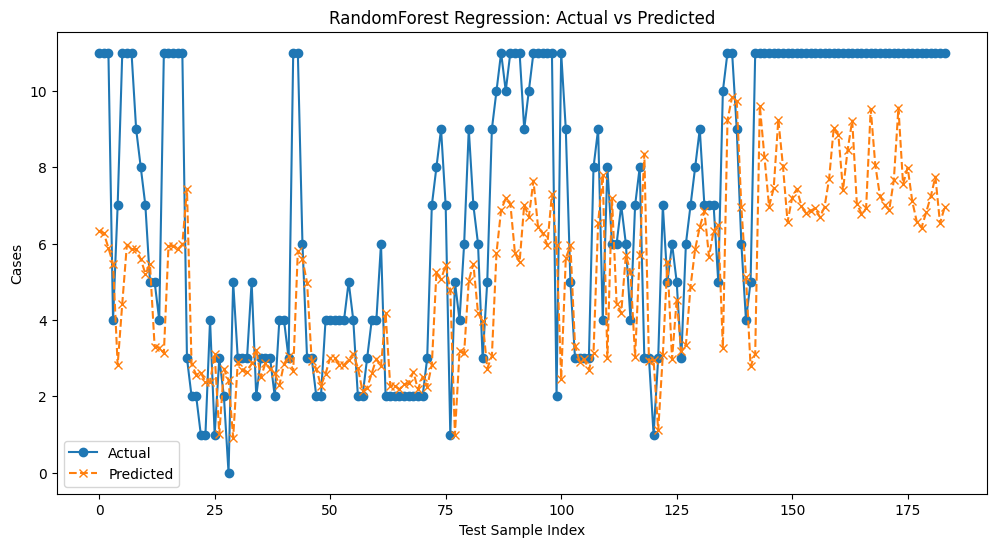

In [57]:
########################################
# RandomForest 시각화 (Loss 추이 & 예측 결과)
########################################
# 테스트셋 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_rf)), y_test_rf, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(y_test_rf)), y_pred_rf, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("RandomForest Regression: Actual vs Predicted")
plt.legend()
plt.show()


In [34]:
########################################
# 6. SARIMAX (ARIMAX)
########################################
sarimax_exog = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",'Cases_lag1','Cases_lag7']
y_train_sar = train_df['Cases']
y_test_sar  = test_df['Cases']
X_train_sar = train_df[sarimax_exog]
X_test_sar  = test_df[sarimax_exog]

sar_model = sm.tsa.statespace.SARIMAX(
    endog=y_train_sar,
    exog=X_train_sar,
    order=(1,0,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sar_result = sar_model.fit(disp=False)
print(sar_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Cases   No. Observations:                  401
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -741.487
Date:                Mon, 03 Feb 2025   AIC                           1532.974
Time:                        07:19:31   BIC                           1632.698
Sample:                             0   HQIC                          1572.470
                                - 401                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SO2          -636.8638    420.077     -1.516      0.130   -1460.199     186.471
CO             -3.3672      3.845     -0.876      0.381     -10.903       4.168
O3              7.7752     20.962      0.371    

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
n_test = len(y_test_sar)
pred_sar = sar_result.predict(
    start=len(y_train_sar),
    end=len(y_train_sar)+n_test-1,
    exog=X_test_sar
)
sar_mae = mean_absolute_error(y_test_sar, pred_sar)
sar_rmse= np.sqrt(mean_squared_error(y_test_sar, pred_sar))
print("[SARIMAX] MAE=%.3f, RMSE=%.3f" % (sar_mae, sar_rmse))


[SARIMAX] MAE=1.629, RMSE=2.190


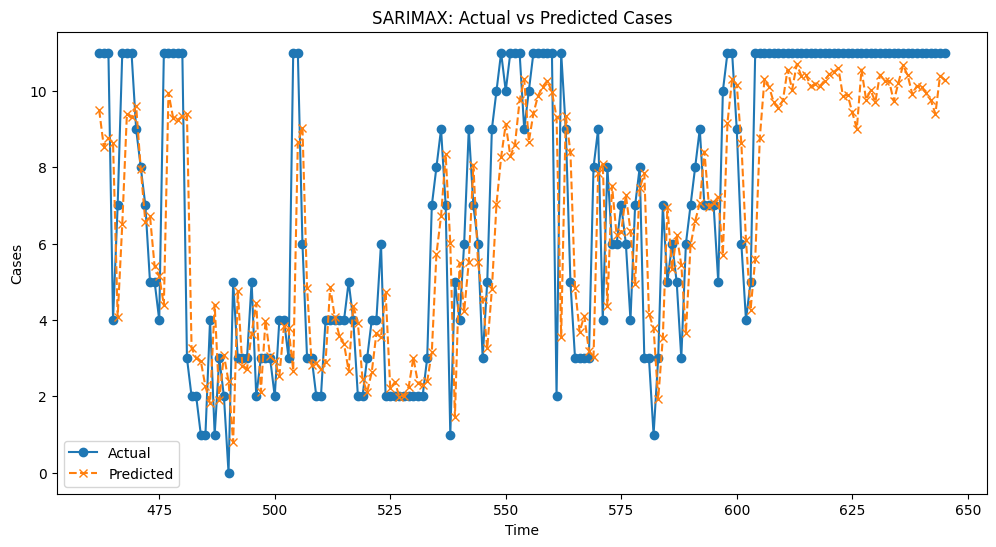

In [58]:
########################################
# SARIMAX 예측 결과 시각화 및 잔차 분석
########################################
import matplotlib.pyplot as plt

# 실제값과 예측값 시각화 (x축은 인덱스 또는 날짜 사용)
plt.figure(figsize=(12,6))
# 만약 y_test_sar의 인덱스가 날짜라면 그대로 사용 가능
plt.plot(y_test_sar.index, y_test_sar, label='Actual', marker='o', linestyle='-')
plt.plot(y_test_sar.index, pred_sar, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cases")
plt.title("SARIMAX: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [36]:
########################################
# 7. LSTM 예시 (시퀀스 생성)
########################################
lstm_feats = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",'Cases_lag1','Cases_lag7']
X_lstm_arr = df[lstm_feats].values
y_lstm_arr = df['Cases'].values

# MinMax
scaler_x_lstm = MinMaxScaler()
X_lstm_scaled = scaler_x_lstm.fit_transform(X_lstm_arr)
scaler_y_lstm = MinMaxScaler()
y_lstm_scaled = scaler_y_lstm.fit_transform(y_lstm_arr.reshape(-1,1)).flatten()

window_size = 7
X_lstm_seq, y_lstm_seq = [], []
for i in range(len(X_lstm_scaled) - window_size):
    X_lstm_seq.append(X_lstm_scaled[i:i+window_size])
    y_lstm_seq.append(y_lstm_scaled[i+window_size])
X_lstm_seq = np.array(X_lstm_seq)
y_lstm_seq = np.array(y_lstm_seq)

cut_date_lstm = pd.to_datetime('2021-07-01')
cut_idx_lstm  = df.index[df['Date'] >= cut_date_lstm][0]
split_idx_lstm = max(0, cut_idx_lstm - window_size)

X_train_lstm = X_lstm_seq[:split_idx_lstm]
y_train_lstm = y_lstm_seq[:split_idx_lstm]
X_test_lstm  = X_lstm_seq[split_idx_lstm:]
y_test_lstm_ = y_lstm_seq[split_idx_lstm:]

# LSTM 모델
lstm_model_ = keras.Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_model_.compile(optimizer='adam', loss='mse')
lstm_model_.summary()

hist_lstm = lstm_model_.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=10, batch_size=16, shuffle=False, verbose=1
)

# 예측
lstm_pred_scaled = lstm_model_.predict(X_test_lstm).flatten()
lstm_pred = scaler_y_lstm.inverse_transform(lstm_pred_scaled.reshape(-1,1)).flatten()
y_test_lstm_ = scaler_y_lstm.inverse_transform(y_test_lstm_.reshape(-1,1)).flatten()

lstm_mae = mean_absolute_error(y_test_lstm_, lstm_pred)
lstm_rmse= np.sqrt(mean_squared_error(y_test_lstm_, lstm_pred))
print("[LSTM] MAE=%.3f, RMSE=%.3f" % (lstm_mae, lstm_rmse))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                7040      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,073
Trainable params: 7,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
23/23 [==============================] - 6s 44ms/step - loss: 0.0553 - val_loss: 0.0848
Epoch 2/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0948 - val_loss: 0.1175
Epoch 3/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0383 - val_loss: 0.0825
Epoch 4/10
23/23 [=

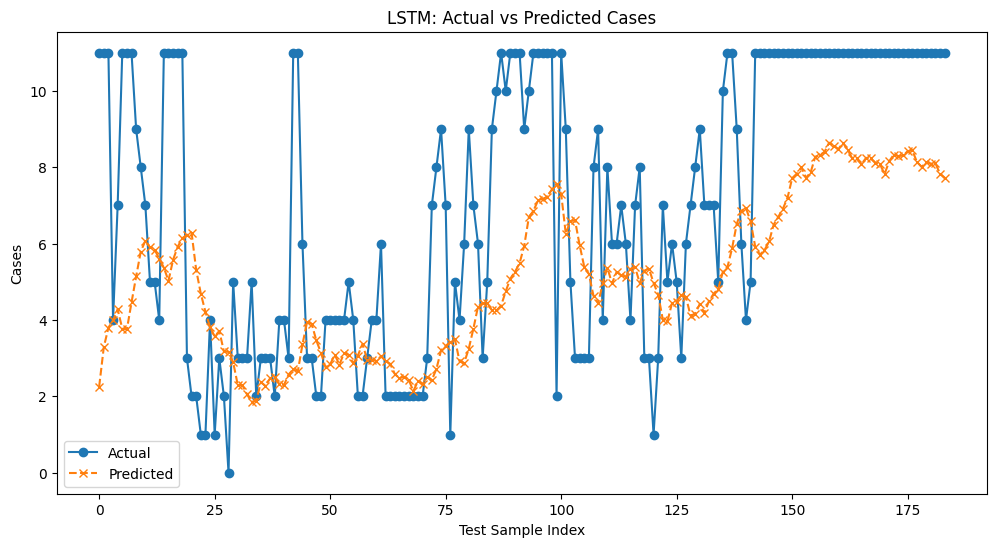

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_lstm_)), y_test_lstm_, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(lstm_pred)), lstm_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("LSTM: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [37]:
########################################
# 8. GRU 예시
########################################
# 기존 X_lstm_seq, y_lstm_seq 재사용
gru_model_ = keras.Sequential([
    GRU(32, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
gru_model_.compile(optimizer='adam', loss='mse')
gru_model_.summary()

hist_gru = gru_model_.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=10, batch_size=16, shuffle=False, verbose=1
)

gru_pred_scaled = gru_model_.predict(X_test_lstm).flatten()
gru_pred = scaler_y_lstm.inverse_transform(gru_pred_scaled.reshape(-1,1)).flatten()
y_test_gru_ = y_test_lstm_

gru_mae = mean_absolute_error(y_test_gru_, gru_pred)
gru_rmse= np.sqrt(mean_squared_error(y_test_gru_, gru_pred))
print("[GRU] MAE=%.3f, RMSE=%.3f" % (gru_mae, gru_rmse))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                5376      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
23/23 [==============================] - 4s 41ms/step - loss: 0.0760 - val_loss: 0.0726
Epoch 2/10
23/23 [==============================] - 0s 12ms/step - loss: 0.0799 - val_loss: 0.0733
Epoch 3/10
23/23 [==============================] - 0s 11ms/step - loss: 0.0660 - val_loss: 0.0969
Epoch 4/10
23/23 [=

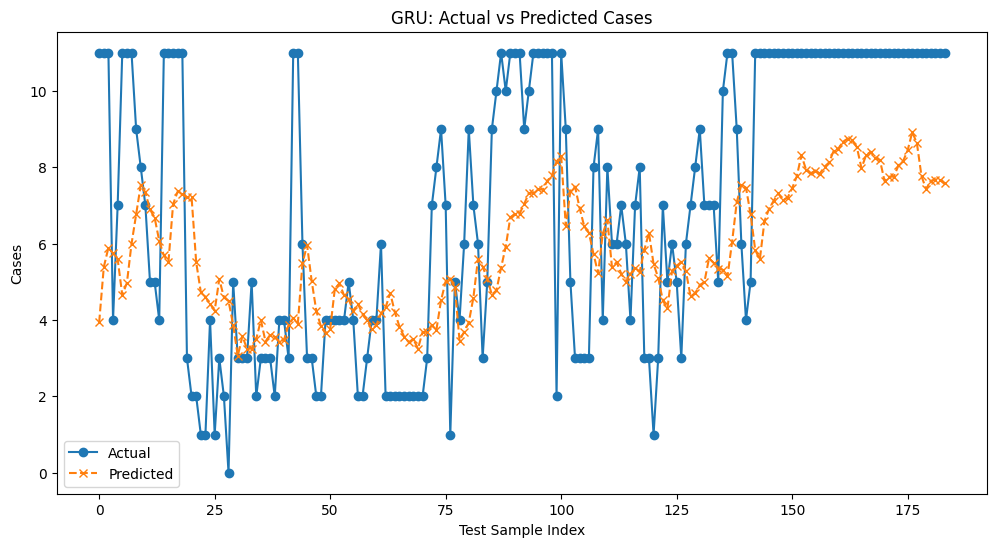

In [60]:
########################################
# GRU 예측 결과 시각화 및 잔차 분석
########################################
import matplotlib.pyplot as plt

# 예측 결과 (Actual vs Predicted) 시각화
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_gru_)), y_test_gru_, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(gru_pred)), gru_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("GRU: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [38]:
########################################
# 9. 앙상블 (단순 가중/Stacking 등)
########################################
# 예시: RandomForest, SARIMAX, LSTM, GRU 결과
# 실제로는 시점 맞춰서, min_len 등 처리 필요

min_len_ = min(len(y_test_rf), len(pred_sar), len(lstm_pred), len(gru_pred))
stack_X = np.column_stack([
    y_pred_rf[-min_len_:],
    pred_sar[-min_len_:],
    lstm_pred[-min_len_:],
    gru_pred[-min_len_:]
])
stack_y = y_test_rf.values[-min_len_:]  # RF기준, 필요시 조정

stack_imputer = SimpleImputer(strategy='mean')
stack_X_ = stack_imputer.fit_transform(stack_X)

stack_final = LinearRegression()
stack_final.fit(stack_X_, stack_y)
stack_pred = stack_final.predict(stack_X_)

stack_mae = mean_absolute_error(stack_y, stack_pred)
stack_rmse= np.sqrt(mean_squared_error(stack_y, stack_pred))
print("[Stacking Ensemble] MAE=%.3f, RMSE=%.3f" % (stack_mae, stack_rmse))

[Stacking Ensemble] MAE=1.530, RMSE=2.122


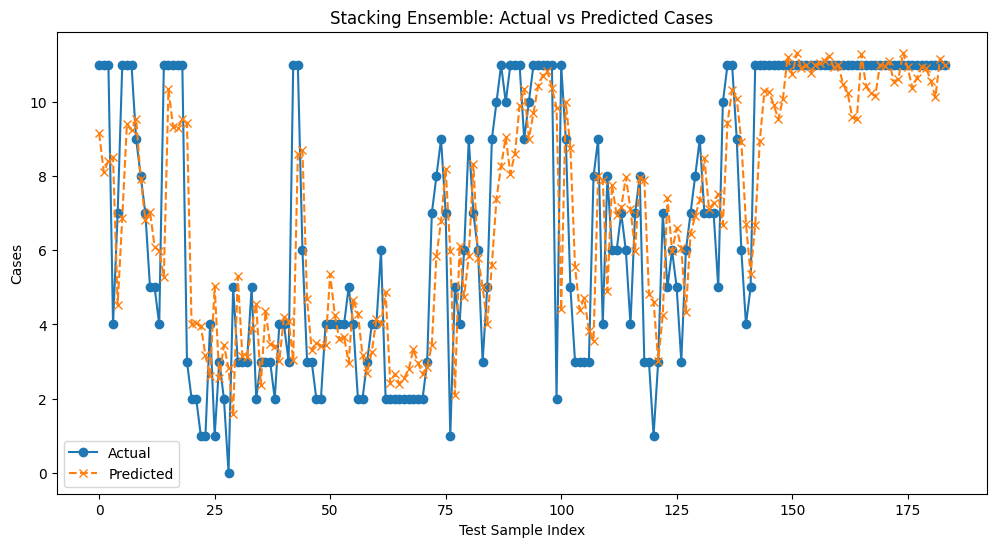

In [61]:
# 예측 결과 시각화: 실제값과 앙상블 예측값 비교
plt.figure(figsize=(12,6))
plt.plot(range(len(stack_y)), stack_y, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(stack_pred)), stack_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("Stacking Ensemble: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [39]:
########################################
# 10. 기타 (TCN, Optuna)
########################################
# 예시: TCN 하이퍼파라미터 최적화 (간단)
# (이미 user code 참고)

# [생략] -> 원하는 경우 Optuna로 TCN 최적화 진행
# 시퀀스 데이터 생성 (window_size=14)
lstm_features = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",'Cases_lag1','Cases_lag7']
X_arr = df[lstm_features].values
y_arr = df['Cases_diff'].values  # 차분 적용된 타겟 사용

# 스케일링 (차분 데이터용 새 스케일러 생성)
scaler_X_diff = StandardScaler()
X_scaled_diff = scaler_X_diff.fit_transform(X_arr)

scaler_y_diff = StandardScaler()
y_scaled_diff = scaler_y_diff.fit_transform(y_arr.reshape(-1,1)).flatten()

# 시퀀스 데이터 생성 (window_size=14)
window_size = 14
X_seq_list, y_seq_list = [], []
for i in range(len(X_scaled_diff) - window_size):
    X_seq_list.append(X_scaled_diff[i:i+window_size])
    y_seq_list.append(y_scaled_diff[i+window_size])
X_seq = np.array(X_seq_list)
y_seq = np.array(y_seq_list)


In [40]:
########################################
# 1. TimeSeriesSplit 설정
########################################

# n_splits=3 정도로 설정 (사용자가 조정 가능)
tscv = TimeSeriesSplit(n_splits=3)

In [47]:
########################################
# 2. Optuna 최적화용 objective 함수
########################################
from tensorflow.keras.models import clone_model
def objective(trial):
    """
    TCN 모델의 하이퍼파라미터를 trial로부터 받아,
    TimeSeriesSplit을 이용한 교차검증 후 평균 validation loss를 반환
    """
    # (1) 하이퍼파라미터 샘플링
    nb_filters_ = trial.suggest_int('nb_filters', 32, 128, step=32)   # TCN 채널 수
    kernel_     = trial.suggest_int('kernel_size', 2, 5)             # 커널크기(2~5)
    dilations_  = trial.suggest_categorical('dilations', [[1,2],[1,2,4],[1,2,4,8]])
    dropout_    = trial.suggest_float('dropout', 0.0, 0.3, step=0.1)
    lr_         = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # (2) 모델 빌드 (TCN + Dense(1))
    # 함수 사용을 줄이기 위해 inline
    base_model = Sequential()
    base_model.add(InputLayer(input_shape=(X_seq.shape[1], X_seq.shape[2]))) #Fixed: Corrected the indentation and argument format for InputLayer
    base_model.add(
        TCN(
            nb_filters=nb_filters_,
            kernel_size=kernel_,
            dilations=dilations_,
            dropout_rate=dropout_,
            return_sequences=False
        )
    )
    base_model.add(Dense(1))

    # (3) 교차검증
    cv_losses = []
    for train_idx, val_idx in tscv.split(X_seq):
        X_train_cv, X_val_cv = X_seq[train_idx], X_seq[val_idx]
        y_train_cv, y_val_cv = y_seq[train_idx], y_seq[val_idx]

        # clone_model: 레이어 구조 복제 (가중치는 재초기화됨)
        model_cv = clone_model(base_model)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_) # Moved optimizer initialization inside the loop
        model_cv.compile(optimizer=optimizer, loss='mse')  # compile 다시 필요

        # 작은 epoch로 검증
        model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=5,         # 필요시 늘리거나 EarlyStopping 사용
            batch_size=32,
            verbose=0,
            shuffle=False
        )

        val_pred = model_cv.predict(X_val_cv)
        loss_    = mean_squared_error(y_val_cv, val_pred)
        cv_losses.append(loss_)

    # (4) 평균 validation loss 반환
    return np.mean(cv_losses)

In [48]:
########################################
# 3. Optuna Study 생성 & 실행
########################################

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, timeout=600)  # n_trials=10, 10분 제한 예시

print("\n===== [Optuna] Best Trial =====")
best_trial = study.best_trial
for k,v in best_trial.params.items():
    print(f"  {k}: {v}")
print("  -> Best Value(MSE):", best_trial.value)


[I 2025-02-03 07:25:08,031] A new study created in memory with name: no-name-a775d8a0-ec92-4f7d-9064-7cf4b6b57d43
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] which is of type list.
  warnings.warn(message)


5/5 [==============================] - 0s 7ms/step


[I 2025-02-03 07:25:29,874] Trial 0 finished with value: 1.8437557503606683 and parameters: {'nb_filters': 96, 'kernel_size': 3, 'dilations': [1, 2, 4], 'dropout': 0.3, 'lr': 0.0006354992412106808}. Best is trial 0 with value: 1.8437557503606683.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] 

5/5 [==============================] - 0s 7ms/step


[I 2025-02-03 07:25:50,821] Trial 1 finished with value: 2.0610128596921817 and parameters: {'nb_filters': 64, 'kernel_size': 2, 'dilations': [1, 2, 4, 8], 'dropout': 0.0, 'lr': 0.0034283998882061037}. Best is trial 0 with value: 1.8437557503606683.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 

5/5 [==============================] - 0s 7ms/step


[I 2025-02-03 07:26:07,177] Trial 2 finished with value: 1.319715630922321 and parameters: {'nb_filters': 96, 'kernel_size': 5, 'dilations': [1, 2], 'dropout': 0.2, 'lr': 0.004032320584933999}. Best is trial 2 with value: 1.319715630922321.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] which 

5/5 [==============================] - 0s 5ms/step


[I 2025-02-03 07:26:22,599] Trial 3 finished with value: 2.9932386137796683 and parameters: {'nb_filters': 32, 'kernel_size': 3, 'dilations': [1, 2, 4], 'dropout': 0.3, 'lr': 0.0002646569615861563}. Best is trial 2 with value: 1.319715630922321.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] w

5/5 [==============================] - 0s 8ms/step


[I 2025-02-03 07:26:41,200] Trial 4 finished with value: 2.5295488246056927 and parameters: {'nb_filters': 64, 'kernel_size': 5, 'dilations': [1, 2, 4], 'dropout': 0.2, 'lr': 0.0002718424534539333}. Best is trial 2 with value: 1.319715630922321.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] w

5/5 [==============================] - 0s 5ms/step


[I 2025-02-03 07:26:54,023] Trial 5 finished with value: 2.0466487360500394 and parameters: {'nb_filters': 64, 'kernel_size': 3, 'dilations': [1, 2], 'dropout': 0.2, 'lr': 0.003135683325722957}. Best is trial 2 with value: 1.319715630922321.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] which

5/5 [==============================] - 0s 4ms/step


[I 2025-02-03 07:27:06,942] Trial 6 finished with value: 1.4987114983507992 and parameters: {'nb_filters': 32, 'kernel_size': 5, 'dilations': [1, 2], 'dropout': 0.1, 'lr': 0.0039517088136841565}. Best is trial 2 with value: 1.319715630922321.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] whic

5/5 [==============================] - 0s 4ms/step


[I 2025-02-03 07:27:19,211] Trial 7 finished with value: 1.3830615043595424 and parameters: {'nb_filters': 32, 'kernel_size': 5, 'dilations': [1, 2], 'dropout': 0.0, 'lr': 0.00601255744530683}. Best is trial 2 with value: 1.319715630922321.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] which 

5/5 [==============================] - 0s 4ms/step


[I 2025-02-03 07:27:35,997] Trial 8 finished with value: 7.716779503024948 and parameters: {'nb_filters': 32, 'kernel_size': 2, 'dilations': [1, 2, 4], 'dropout': 0.1, 'lr': 0.00018233105851627588}. Best is trial 2 with value: 1.319715630922321.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] w

5/5 [==============================] - 0s 5ms/step


[I 2025-02-03 07:27:49,306] Trial 9 finished with value: 1.5038322504787178 and parameters: {'nb_filters': 64, 'kernel_size': 4, 'dilations': [1, 2], 'dropout': 0.3, 'lr': 0.001873209268247349}. Best is trial 2 with value: 1.319715630922321.



===== [Optuna] Best Trial =====
  nb_filters: 96
  kernel_size: 5
  dilations: [1, 2]
  dropout: 0.2
  lr: 0.004032320584933999
  -> Best Value(MSE): 1.319715630922321


In [49]:
########################################
# 4. 최적 파라미터로 최종 모델 학습
########################################
# best hyperparams
best_params = best_trial.params
nb_filters_best   = best_params['nb_filters']
kernel_best       = best_params['kernel_size']
dilations_best    = best_params['dilations']
dropout_best      = best_params['dropout']
lr_best           = best_params['lr']

final_model = Sequential()
final_model.add(InputLayer(input_shape=(X_seq.shape[1], X_seq.shape[2])))
final_model.add(
    TCN(
        nb_filters=nb_filters_best,
        kernel_size=kernel_best,
        dilations=dilations_best,
        dropout_rate=dropout_best,
        return_sequences=False
    )
)
final_model.add(Dense(1))

final_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_best)
final_model.compile(optimizer=final_optimizer, loss='mse')
final_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_12 (TCN)                (None, 96)                151392    
                                                                 
 dense_16 (Dense)            (None, 1)                 97        
                                                                 
Total params: 151,489
Trainable params: 151,489
Non-trainable params: 0
_________________________________________________________________


In [50]:
# 훈련/검증을 user가 원하는 방식으로 나눠 재학습
# 예) 마지막 구간을 test로 쓰고, 앞부분을 train
split_ratio = 0.8
split_idx   = int(len(X_seq)*split_ratio)
X_train_final, X_test_final = X_seq[:split_idx], X_seq[split_idx:]
y_train_final, y_test_final = y_seq[:split_idx], y_seq[split_idx:]

history_final = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    shuffle=False,
    verbose=1
)

Epoch 1/10
13/13 [==============================] - 8s 180ms/step - loss: 17.1554 - val_loss: 2.3637
Epoch 2/10
13/13 [==============================] - 1s 40ms/step - loss: 2.7428 - val_loss: 2.0101
Epoch 3/10
13/13 [==============================] - 0s 34ms/step - loss: 1.1007 - val_loss: 1.4466
Epoch 4/10
13/13 [==============================] - 0s 23ms/step - loss: 0.8977 - val_loss: 1.3874
Epoch 5/10
13/13 [==============================] - 0s 26ms/step - loss: 0.8618 - val_loss: 1.3616
Epoch 6/10
13/13 [==============================] - 0s 24ms/step - loss: 0.8456 - val_loss: 1.3593
Epoch 7/10
13/13 [==============================] - 0s 22ms/step - loss: 0.7969 - val_loss: 1.3557
Epoch 8/10
13/13 [==============================] - 0s 23ms/step - loss: 0.7792 - val_loss: 1.3649
Epoch 9/10
13/13 [==============================] - 0s 26ms/step - loss: 0.7592 - val_loss: 1.3781
Epoch 10/10
13/13 [==============================] - 0s 22ms/step - loss: 0.7293 - val_loss: 1.3691


In [53]:
########################################
# 5. 최종 모델 예측 & 성능 평가
########################################
y_pred_final = final_model.predict(X_test_final)
mse_final    = mean_squared_error(y_test_final, y_pred_final)
mae_tcn = mean_absolute_error(y_test_final, y_pred_final)
rmse_final   = np.sqrt(mse_final)
print("\n===== [Final TCN Model] =====")
print(f"Test MSE={mse_final:.4f}, RMSE={rmse_final:.4f}, MAE={mae_tcn:.4f}")

4/4 [==============================] - 0s 10ms/step

===== [Final TCN Model] =====
Test MSE=1.2338, RMSE=1.1108, MAE=0.7400


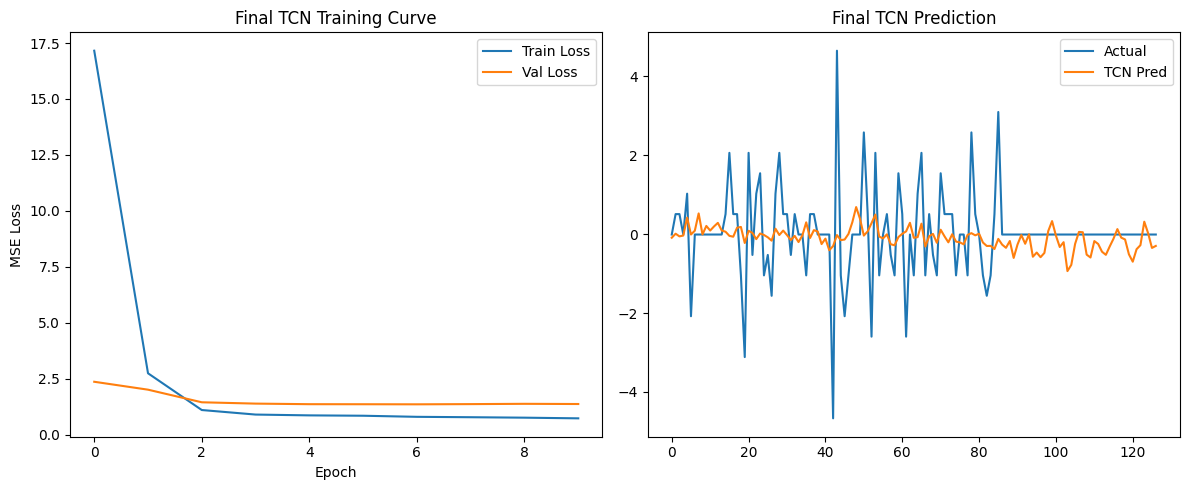

In [54]:
########################################
# 6. 시각화 (Loss 추이 & 예측 결과)
########################################
plt.figure(figsize=(12,5))

# (1) 학습 곡선
plt.subplot(1,2,1)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.title("Final TCN Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

# (2) 예측 vs 실제
plt.subplot(1,2,2)
plt.plot(range(len(y_test_final)), y_test_final, label='Actual')
plt.plot(range(len(y_test_final)), y_pred_final, label='TCN Pred')
plt.title("Final TCN Prediction")
plt.legend()

plt.tight_layout()
plt.show()

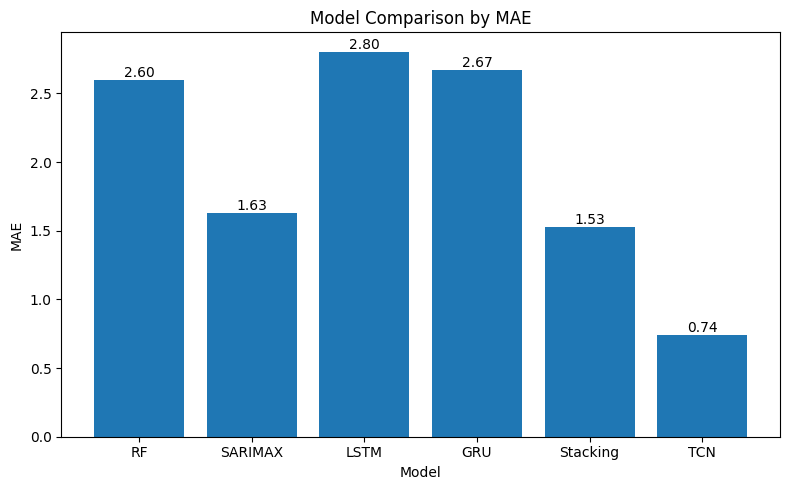

In [55]:
########################################
# 11. 결과 비교 시각화
########################################
model_names = ['RF','SARIMAX','LSTM','GRU','Stacking', 'TCN']
mae_list = [rf_mae, sar_mae, lstm_mae, gru_mae, stack_mae, mae_tcn]

plt.figure(figsize=(8,5))
bars = plt.bar(model_names, mae_list)
plt.title("Model Comparison by MAE")
plt.xlabel("Model")
plt.ylabel("MAE")
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2., h, f"{h:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
########################################
# 12. 리소스 정리
########################################
del X_lstm_scaled, y_lstm_scaled
gc.collect()

print("\n=== ALL DONE ===")